In [18]:
import cv2
import numpy as np
import random
import torch
import torchvision
from PIL import Image
from IPython import display
from torchvision.transforms import transforms
import time

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if (torch.cuda.device_count()>0):
    print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA GeForce GTX 1080


In [4]:
import torchvision.models

In [6]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights="DEFAULT")

In [7]:
model.to(device).eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

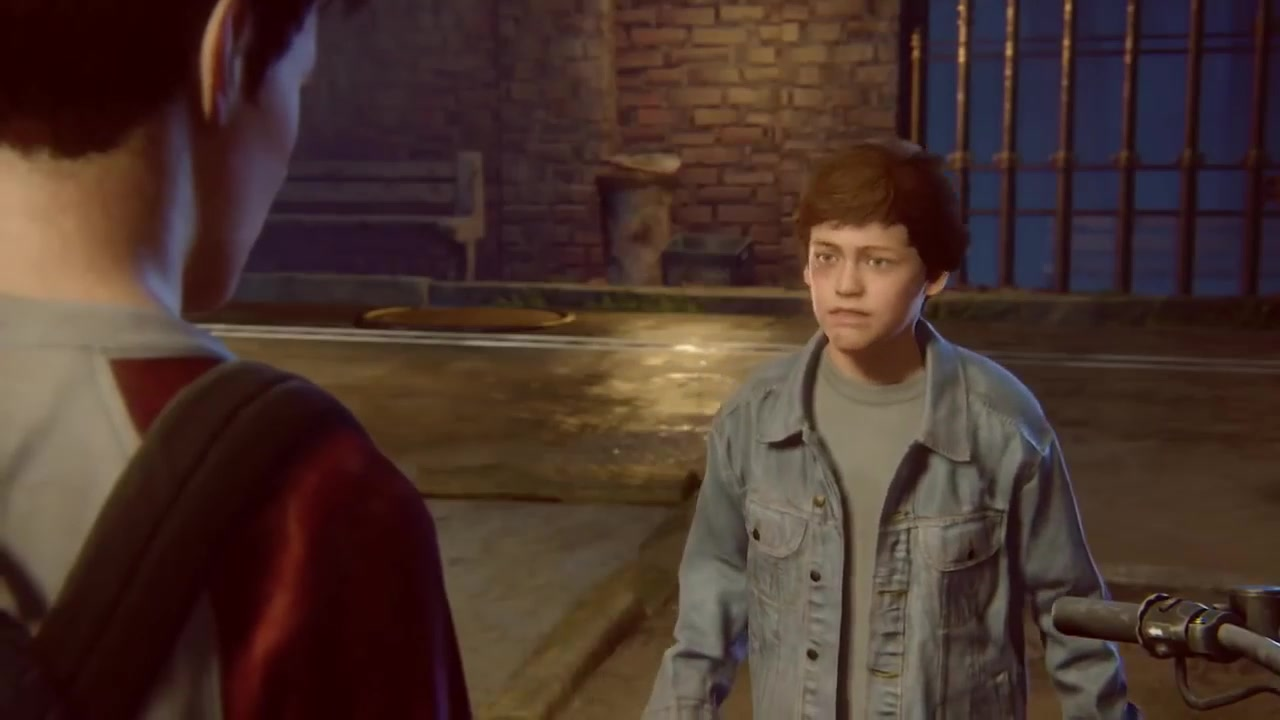

In [36]:
filename = "./data/Train/Game/01_frames/01_frame_0303.jpg"
trimmed_name = ''.join(filename.split("/")[-1].split(".")[:-1])

in_frame = cv2.imread(filename, cv2.IMREAD_COLOR)

# Display the image
d = display.display(None, display_id=True)
in_frame_display = cv2.cvtColor(in_frame, cv2.COLOR_BGR2RGB) # Convert from CV2's BGR to RGB
d.update(Image.fromarray(in_frame_display))

In [37]:
# Analyze the image
in_frame_processing = cv2.cvtColor(in_frame, cv2.COLOR_BGR2RGB) # Convert from CV2's BGR to RGB
in_frame_processing = transform(in_frame_processing) # Convert the image to tensor
in_frame_processing = in_frame_processing.unsqueeze(0).to(device) # add a batch dimension

In [38]:
with torch.no_grad():
    outputs = model(in_frame_processing)

In [39]:
# The 91 COCO class names
coco_names = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

# Generate a set of color for drawing different classes
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

# Get individual types of output from the outputs variable
scores = list(outputs[0]['scores'].detach().cpu().numpy()) # Get scores
threshold = 0.965
print(scores) # The scores are sorted from largest to the shortest
thresholded_objects = [scores.index(i) for i in scores if i > threshold] # Get an index for the objects having the scores > a threshold of 0.965
thresholded_objects_count = len(thresholded_objects) # Total objects having scores > threshold
masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy() # Get the segmentation masks
masks = masks[:thresholded_objects_count] # Discard masks for objects that are below threshold by only taking the beginning of the list
boxes = [[(i[0], i[1]), (i[2], i[3])]  for i in outputs[0]['boxes'].detach().cpu()] # Get the bounding boxes, in (x1, y1), (x2, y2) format
boxes = boxes[:thresholded_objects_count] # Discard bounding boxes for objects that are below threshold by only taking the beginning of the list
labels = [coco_names[i] for i in outputs[0]['labels']] # Get the classes labels

# Print all the detected objects
for i in range(0, len(outputs[0]['scores'])):
    print(coco_names[outputs[0]['labels'][i]], ":", float(outputs[0]['scores'][i]), "(", int(outputs[0]['boxes'][i][0]), int(outputs[0]['boxes'][i][1]), int(outputs[0]['boxes'][i][2]), int(outputs[0]['boxes'][i][3]) ,")")

[0.9995345, 0.9878099, 0.3246984, 0.25870022, 0.22554548, 0.16654623, 0.1612942, 0.08686275, 0.06607577, 0.064820215, 0.054106496]
person : 0.9995344877243042 ( 638 137 1125 712 )
person : 0.9878098964691162 ( 0 0 519 710 )
baseball bat : 0.32469838857650757 ( 1051 590 1279 671 )
bicycle : 0.2587002217769623 ( 1054 586 1280 691 )
bench : 0.2255454808473587 ( 240 151 490 285 )
bottle : 0.16654622554779053 ( 1045 591 1275 672 )
chair : 0.16129420697689056 ( 4 332 454 713 )
chair : 0.08686275035142899 ( 0 361 67 718 )
person : 0.06607577204704285 ( 0 355 477 713 )
cup : 0.06482021510601044 ( 602 179 674 287 )
person : 0.05410649627447128 ( 0 0 382 477 )


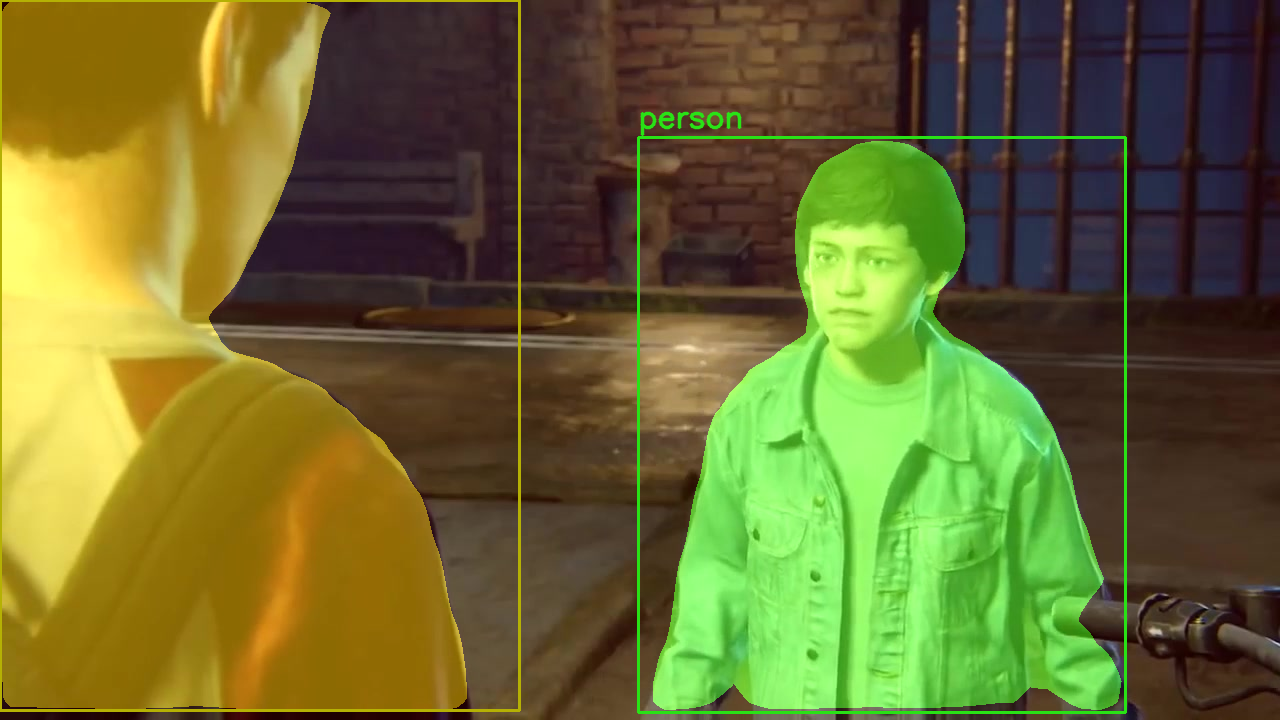

In [40]:
# Get the image 
out_frame = in_frame.copy()
out_frame = np.array(out_frame)

# Draw the segmentation masks with the text labels
for i in range(len(masks)): # For all detected objects with score > threshold
    color = COLORS[random.randrange(0, len(COLORS))] # Pick a random color
    red_map = np.zeros_like(masks[i]).astype(np.uint8) # Initialize an empty mask for each of the RGB channels
    green_map = np.zeros_like(masks[i]).astype(np.uint8)
    blue_map = np.zeros_like(masks[i]).astype(np.uint8)
    red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1] = color # Set the color of the masked pixels
    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2) # Combine the three channels of the mask
    cv2.addWeighted(out_frame, 1.0, segmentation_map, 0.6, 0.0, out_frame) # Apply the mask onto the image
    cv2.rectangle(out_frame, (int(boxes[i][0][0]),int(boxes[i][0][1])), (int(boxes[i][1][0]),int(boxes[i][1][1])), color, 2) # Draw the bounding boxes
    cv2.putText(out_frame , labels[i], (int(boxes[i][0][0]), int(boxes[i][0][1])-10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA) # Draw the class label as text

# Save the image
cv2.imwrite(f"./output/{time.time()}_{trimmed_name}.jpg", out_frame)

# Display the image
d = display.display(None, display_id=True)
out_frame_display = cv2.cvtColor(out_frame, cv2.COLOR_BGR2RGB) # Convert from CV2's BGR to RGB
d.update(Image.fromarray(out_frame_display))